# Analysis of the ISM Manufacturing Index

## What is the ISM Index?

The Institute for Supply Management (ISM) "is the first and largest not-for-profit professional supply management organization worldwide. Founded in 1915, ISM has over 50,000 members across 100 countries.For more than a century, Institute for Supply Management® (ISM) has impacted supply management and the purchasing profession through best in class education, certification, leadership development and research."

More importantly, they publish the monthly "Manufacturing Report on Business" ([here is the February 2023 report](https://www.ismworld.org/supply-management-news-and-reports/reports/ism-report-on-business/pmi/february/)) which contains a qualitative and quantitative analysis of the US Manufacturing sector. The qualitative portion highlights anecdotes from surveys of manufacturing purchasing managers and supply chain executives from thousands of companies within a variety of sectors. These qualtative remarks are summarized quantitatively in the diffusion index known as the "Manufacturing PMI" (Purchasing Managers Index).

The ISM PMI/Manufacturing Index is a diffusion index comprised of several sub-indices. The survey participants are asked to rank their companies experience related to the sub-indices (such as higher or lower, faster or slower etc), and then all of these are aggregated up across companies. The sub-indices are:

- New Orders
- Production
- Employment
- Supplier Deliveries
- Inventories
- Customers' Inventories
- Prices
- Backlog of Orders
- New Export Orders
- Imports

Some of the subindices are aggregated up to form the the broader index. Specifically, a reading of above 50 indicates an "expansion" in "economic activity" (as defined by the broad range of sub-indices), whereas a reading of below 50 indicates a "contraction". Further, the results are internally consistent. Specifically, an analysis of the sub-indices (whose data is readily available in Bloomberg), shows that the difference between New Orders (a proxy of new demand) and Inventories (a proxy of supply) is very highly correlated with Prices. That is when demand outstrips supply, prices tend to increase. Further, the Employment sub-index is somewhat correlated with other measures of employment.

An important note regarding the index (and its subcomponents) is that based on the survey questions, the index does not represent a "level", but rather a rate of change. Specifically:

*"**Survey responses reflect the change, if any, in the current month compared to the previous month**. For each of the indicators measured (...), this report shows the percentage reporting each response, the net difference between the number of responses in the positive economic direction (higher, better and slower for Supplier Deliveries) and the negative economic direction (lower, worse and faster for Supplier Deliveries), and the diffusion index. Responses are raw data and are never changed. The diffusion index includes the percent of positive responses plus one-half of those responding the same (considered positive)."*

A more indepth description of the index can be found in the "Data and Method of Presentation" section of the monthly report. 

## Mentions of the ISM in the Literature (JPM)

(Direct References)
- [The Early Bird Catches the Intraday Trend](https://joi-pm-research-com.myaccess.library.utoronto.ca/content/iijinvest/31/1/47.full.pdf)
    - "Rosa (2013) investigates the impact of major macroeconomic releases such as FOMC minutes and balance-of-risk statements, non-farm payrolls, and the ISM purchasing managers’ index (PMI). All releases are found to significantly impact intraday volatility, with an absorption rate of the order of 1 hour. The FOMC balance-of-risk statement and the ISM have the strongest impact on US markets"
    - "Gao et al. (2018) show that intraday trends in an S&P 500 ETF are stronger on the days of important economic releases. Trends arise due to investors being slow to react to new information and to rebalance their portfolios. Considering the same indicators as these authors and adding the ISM manufacturing index (ISM PMI), Exhibit 12 presents the link between US news releases and equity returns from open to close.12 FOMC decisions about interest rates and money supply are a major reason for stock market volatility across the globe. So are early indicators of economic activity in the US."
    - S&P500 returns (open to close) are 84bps higher on days when the ISM Index is released (normalized by the volatility of non-release days) 
- [Investing in US 10-Year Yields with News Sentiment](https://joi-pm-research-com.myaccess.library.utoronto.ca/content/iijinvest/27/4/43.full.pdf)
    - Use the ISM index, a variety of other macro data, and news sentiment to predict the US 10 year Treasury yield to inform a trading strategy

(Indirect References)
- [Leading Economic Indicator and Global Stock Market Returns](https://jwm-pm-research-com.myaccess.library.utoronto.ca/content/iijwealthmgmt/25/1/122.full.pdf)
    - Strategy utilizing the Conference Board's LEI (which contains ISM sub-components) outperforms buy-and-hold
- [OutDex™ to Outperform an Index: Incorporating the Best of Active and Passive Investment Strategies](https://jii-pm-research-com.myaccess.library.utoronto.ca/content/iijindinv/6/2/46.full.pdf)
    - Posit that macro factors can be based on Chen, Roll & Ross (1986), or simply on the ISM Index
- [Measuring Bond Investors’ Risk Appetite Using the Interest Rate Term Structure](https://joi-pm-research-com.myaccess.library.utoronto.ca/content/iijinvest/28/6/115.full.pdf)
    - The author's new found yield curve factor (the duration of the hump in the yield curve) is correlated with several measure of US economic activity, including the ISM Index
- [Business Cycle–Related Timing of Alternative Risk Premia Strategies](https://jai-pm-research-com.myaccess.library.utoronto.ca/content/iijaltinv/22/4/8.full.pdf)
    - Use the ISM Index as an indicator of Producer Sentiment, which is subsequently used to show that economic conditions are highly correlated with the time-varying returns of alternative risk premia strategies

In [287]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.stattools import grangercausalitytests as GrangerCausality
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [283]:
# Data
data = pd.read_excel("Bloomberg Data.xlsx", sheet_name="Clean")
data.index = data['Date']
data.index = pd.DatetimeIndex(data.index, freq="BM")
data = data[['S&P Price Index', "S&P TR Index", 'US 3M', 'US 2Y', 'US 10Y', 'ISM Manufacturing']]
data.columns = ['SP_price', "SP_tr",'3m','2y','10y','ISM']

In [284]:
# Transformations
data['SP_mom'] = np.log(data['SP_price'] / data['SP_price'].shift(1))
data['SP_yoy'] = np.log(data['SP_price'] / data['SP_price'].shift(12))

data['SPtr_mom'] = np.log(data['SP_tr'] / data['SP_tr'].shift(1))
data['SPtr_yoy'] = np.log(data['SP_tr'] / data['SP_tr'].shift(12))

data['10-2'] = data['10y'] - data['2y']
data['10-3m'] = data['10y'] - data['3m']

data["10y_yoy"] = data['10y'] - data['10y'].shift(12)
data["10y_mom"] = data['10y'] - data['10y'].shift(1)

data["ISM_diff"] = data["ISM"].diff(1)

# data['ISM'][data['ISM'].isna()==True]
data = data.loc['1948':] # ISM begins in 1948

### Preliminary Plots

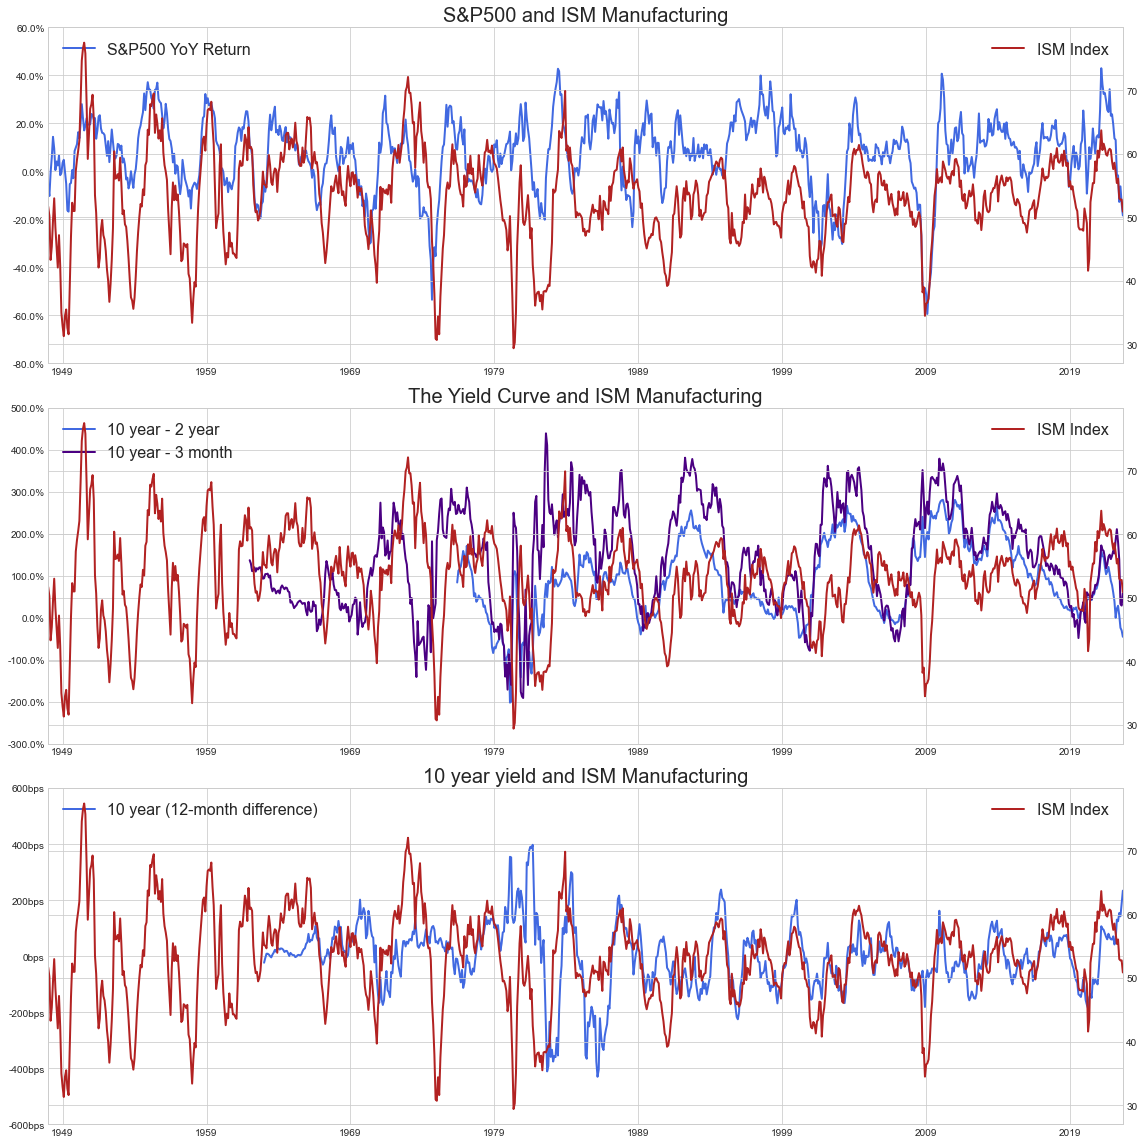

In [228]:
fig, ax = plt.subplots(3, 1, figsize=(16,16))


ax1 = data["SP_yoy"].plot(ax=ax[0], legend=True, label="S&P500 YoY Return", color='royalblue', linewidth=2)
ax11 = ax1.twinx()
ax11 = data["ISM"].plot(ax=ax11, legend=True, label="ISM Index", color='firebrick', linewidth=2)
ax1.set_title('S&P500 and ISM Manufacturing', fontsize=20)
ax1.legend(loc=2, fontsize=16)
ax11.legend(loc=0, fontsize=16)
ax1.set_xlabel("")
ax1.set_yticks(ax1.get_yticks())
y_labels = ax1.get_yticks()
ax1.set_yticklabels([f'{x:0.1%}' for x in y_labels])


ax2 = data["10-2"].plot(ax=ax[1], legend=True, label="10 year - 2 year", color='royalblue', linewidth=2)
ax2 = data["10-3m"].plot(ax=ax[1], legend=True, label="10 year - 3 month", color='indigo', linewidth=2)
ax22 = ax2.twinx()
ax22 = data["ISM"].plot(ax=ax22, legend=True, label="ISM Index", color='firebrick', linewidth=2)
ax2.set_title('The Yield Curve and ISM Manufacturing', fontsize=20)
ax2.legend(loc=0, fontsize=16)
ax22.legend(loc=1, fontsize=16)
ax2.set_xlabel("")
ax2.set_yticks(ax2.get_yticks())
y_labels = ax2.get_yticks()
ax2.set_yticklabels([f'{x:0.1%}' for x in y_labels])


ax3 = data["10y_yoy"].plot(ax=ax[2], legend=True, label="10 year (12-month difference)", color='royalblue', linewidth=2)
ax33 = ax3.twinx()
ax33 = data["ISM"].plot(ax=ax33, legend=True, label="ISM Index", color='firebrick', linewidth=2)
ax3.set_title('10 year yield and ISM Manufacturing', fontsize=20)
ax3.legend(loc=2, fontsize=16)
ax33.legend(loc=1, fontsize=16)
ax3.set_xlabel("")
ax3.set_yticks(ax3.get_yticks())
y_labels = ax3.get_yticks()
ax3.set_yticklabels([f'{100*x:0.0f}bps' for x in y_labels])


fig.tight_layout()
plt.show()

With respect to the S&P500 YoY % Return and the ISM Manufacturing Index, it is clear that from the early 2000's until the present, the relationship is much closer together (and somewhat contemporaneous), and nearly one-to-one. Further, during crisis times, markets tend to contract by less than the ISM, suggesting some non-linearity during severe economic contractions (ie. ISM below 50). Pre early 2000's, back until about the mid 1980's, the correlation looks weaker. Pre mid 1980's, the correlation appears higher, however the ISM is much more volatile, suggesting a beta less than 1.

Comparing the ISM Index to the slope of the US Treasury yield curve, it can be seen that the yield curve generally leads the ISM, however the length of the lead does not appear constant. If the yield curve is thought of as a slower moving barometer of the state of the economy, the ISM Index is surely a real-time indicator, that tends to be more volatile. 

Lastly comparing the ISM Index to the 10 year Treasury yield itself, it can be seen that the the 12 month difference in the yield is very highly correlated with the index. This is especially true post the early 1990's. This suggests that if the 10 year yield is thought of as a proxy for the neutral rate of the US economy, or a proxy for nominal economic growth, then the ISM Index closely tracks the yearly change in economic growth (or rather the market's view of it at the monthly frequency).

### Time-Series Analysis

#### Time-series Diagnostics

In [229]:
def plot_acf_pacf(x):
    '''
    Function to plot the ACF and PACF.
    '''
    
    fig, ax = plt.subplots(1, 2, figsize=(24,8))
    plot_acf(x, ax=ax[0], alpha=0.05, use_vlines=True);
    plot_pacf(x, ax=ax[1], alpha=0.05, use_vlines=True);

C:\Users\sroma\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


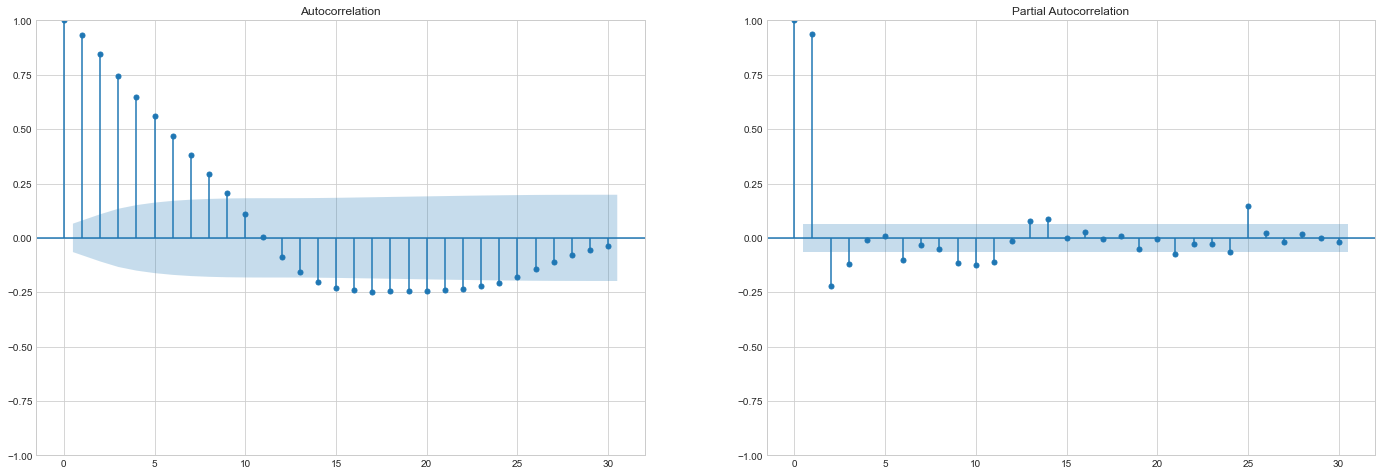

In [230]:
# Autocorrelation Structure of the ISM Index
plot_acf_pacf(data['ISM'])

ACF significant until the 9th lag, while PACF significant for the first 2 lags. 
PACF suggests that an AR(2) may be appropriate, while the ACF suggests that differencing is likely required.

In [231]:
def adf_test(timeseries):
    
    print('''H0: Unit Root
Results of Dickey-Fuller Test:
            ''')
    dftest = adfuller(timeseries, autolag="BIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    


def kpss_test(timeseries):
    
    print('''    
    
H0: Trend Stationary
Results of KPSS Test:
            ''')    
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
        )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [232]:
# Stationary Tests
adf_test(data['ISM'])
kpss_test(data['ISM'])

H0: Unit Root
Results of Dickey-Fuller Test:
            
Test Statistic                -7.412108e+00
p-value                        7.089564e-11
#Lags Used                     2.000000e+00
Number of Observations Used    8.940000e+02
Critical Value (1%)           -3.437686e+00
Critical Value (5%)           -2.864778e+00
Critical Value (10%)          -2.568494e+00
dtype: float64
    
    
H0: Trend Stationary
Results of KPSS Test:
            
Test Statistic            0.081026
p-value                   0.100000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\sroma\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


ADF p-value of (statistically) 0 means that we reject the null of a unit root (implying stationarity), while KPSS p-value of (potentially greater than) 0.10 indicates that we fail to reject stationarity (implying non-stationarity). This suggests that differencing the series should make it stationary. 

Overall, this suggests that an AR(2) should be used to model the ISM, and that differencing is required.

H0: Unit Root
Results of Dickey-Fuller Test:
            
Test Statistic                 -24.963067
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    895.000000
Critical Value (1%)             -3.437678
Critical Value (5%)             -2.864775
Critical Value (10%)            -2.568492
dtype: float64
    
    
H0: Trend Stationary
Results of KPSS Test:
            
Test Statistic           0.006993
p-value                  0.100000
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\sroma\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\sroma\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


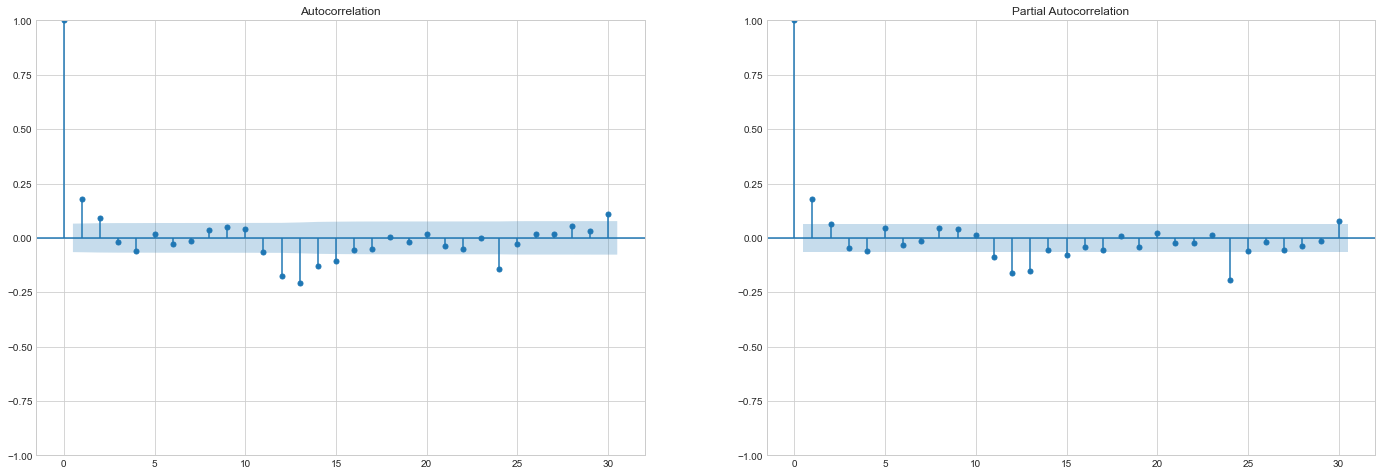

In [234]:
plot_acf_pacf(data['ISM_diff'].dropna())

adf_test(data['ISM_diff'].dropna())
kpss_test(data['ISM_diff'].dropna())

The first difference still appears non-stationary according to KPSS, which implies that the series may be stationary around some non-linear time trend. However the autocorrelation is only significant at the first lag, so differencing eliminated the persistence. Hence an ARMA(1,1) should model the first difference well.

Alternatively, it may be worthwhile to test for cointegration between the ISM and other data given potentially non-stationarity.

#### ISM Time Series Predictability - Univariate
##### In-Sample

In [240]:
# AR(2) of ISM Level
model1 = ARIMA(data['ISM'], order=(2,0,0)).fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                    ISM   No. Observations:                  897
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2094.223
Date:                Sun, 05 Mar 2023   AIC                           4196.446
Time:                        12:37:04   BIC                           4215.642
Sample:                    01-30-1948   HQIC                          4203.780
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.0144      1.047     50.637      0.000      50.962      55.066
ar.L1          1.1371      0.025     44.858      0.000       1.087       1.187
ar.L2         -0.2170      0.025     -8.819      0.0

In [243]:
data['ISM_hat1'] = model1.predict()
# data[['ISM','ISM_hat1']].plot(figsize=(16,8))
mse(data['ISM'], data['ISM_hat1'])

6.230153523796814

In [317]:
# ARMA(1,1) of ISM 1st difference
model2 = ARIMA(data['ISM'], order=(1,1,1)).fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                    ISM   No. Observations:                  897
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2112.362
Date:                Sun, 05 Mar 2023   AIC                           4230.724
Time:                        14:04:08   BIC                           4245.118
Sample:                    01-30-1948   HQIC                          4236.224
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3698      0.139      2.668      0.008       0.098       0.642
ma.L1         -0.1960      0.148     -1.325      0.185      -0.486       0.094
sigma2         6.5349      0.228     28.693      0.0

9.507703858675425

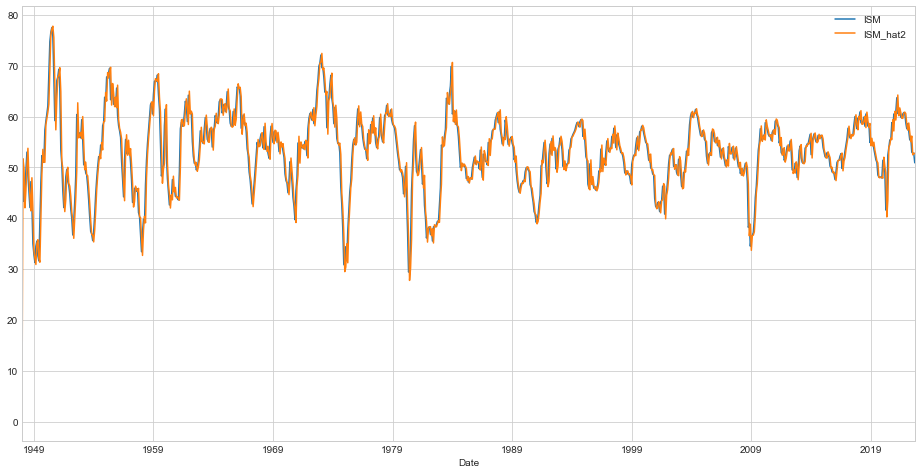

In [348]:
data['ISM_hat2'] = model2.predict()
data[['ISM','ISM_hat2']].plot(figsize=(16,8))
mse(data['ISM'], data['ISM_hat2'])

The MSE of the AR(2) is lower suggesting that it outperforms the ARMA(1,1) on the first difference of ISM (to be expected in-sample with potentially non-stationary data).

In [352]:
model_test = ARIMA(data['ISM_diff'], order=(1,0,1)).fit()
# data['ISM_hat_test'] = model_test.predict().cumsum() + data['ISM']

In [353]:
data['ISM_diff']

Date
1948-01-30    NaN
1948-02-27   -1.5
1948-03-31   -6.9
1948-04-30    2.1
1948-05-31    4.1
             ... 
2022-05-31    0.7
2022-06-30   -3.1
2022-07-29   -0.2
2022-08-31    0.0
2022-09-30   -1.9
Freq: BM, Name: ISM_diff, Length: 897, dtype: float64

In [354]:
model_test.predict()

Date
1948-01-30   -0.002274
1948-02-27   -0.002274
1948-03-31   -0.272619
1948-04-30   -1.256269
1948-05-31    0.117425
                ...   
2022-05-31   -0.343850
2022-06-30    0.052861
2022-07-29   -0.530064
2022-08-31   -0.140130
2022-09-30   -0.028906
Freq: BM, Name: predicted_mean, Length: 897, dtype: float64

2.8632123361995236

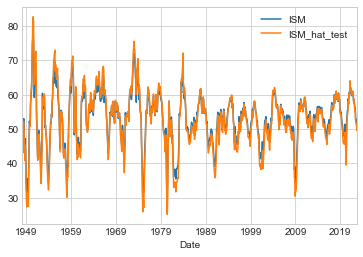

In [356]:
data[['ISM', 'ISM_hat_test']].plot()
mse(data['ISM'], data['ISM_hat_test'].dropna())

##### Out-of-Sample

#### ISM Time Series Predictability - Multivariate
##### In-Sample
Potentially extra information can be extracted from the S&P500 or 10 year Treasury Yield

In [279]:
# Granger Causality in Levels
type(GrangerCausality(data[['ISM','SP_yoy']], maxlag=4))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.5914 , p=0.0000  , df_denom=893, df_num=1
ssr based chi2 test:   chi2=30.6942 , p=0.0000  , df=1
likelihood ratio test: chi2=30.1801 , p=0.0000  , df=1
parameter F test:         F=30.5914 , p=0.0000  , df_denom=893, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.3286 , p=0.0000  , df_denom=890, df_num=2
ssr based chi2 test:   chi2=42.8969 , p=0.0000  , df=2
likelihood ratio test: chi2=41.9006 , p=0.0000  , df=2
parameter F test:         F=21.3286 , p=0.0000  , df_denom=890, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.0890 , p=0.0000  , df_denom=887, df_num=3
ssr based chi2 test:   chi2=42.6005 , p=0.0000  , df=3
likelihood ratio test: chi2=41.6167 , p=0.0000  , df=3
parameter F test:         F=14.0890 , p=0.0000  , df_denom=887, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=10.8152 , p=0.0000  

dict

The null of the Granger Causality Test is that neither variablr Granger causes the other. All of the p-values are 0 indicating that we reject the null that either variable do not Granger Cause eachother. Hence lagged values of each help in predicting the other. 

In [280]:
type(GrangerCausality(data[['ISM','10y_yoy']].dropna(), maxlag=4))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.0346  , p=0.0027  , df_denom=713, df_num=1
ssr based chi2 test:   chi2=9.0726  , p=0.0026  , df=1
likelihood ratio test: chi2=9.0156  , p=0.0027  , df=1
parameter F test:         F=9.0346  , p=0.0027  , df_denom=713, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.9526 , p=0.0000  , df_denom=710, df_num=2
ssr based chi2 test:   chi2=22.0594 , p=0.0000  , df=2
likelihood ratio test: chi2=21.7259 , p=0.0000  , df=2
parameter F test:         F=10.9526 , p=0.0000  , df_denom=710, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3806  , p=0.0003  , df_denom=707, df_num=3
ssr based chi2 test:   chi2=19.3314 , p=0.0002  , df=3
likelihood ratio test: chi2=19.0744 , p=0.0003  , df=3
parameter F test:         F=6.3806  , p=0.0003  , df_denom=707, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.1114  , p=0.0005  

dict

Similar to above, the p-values all indicate that additional information is contained in lags of the other variable.

In [286]:
# Granger Causality in monthly changes
type(GrangerCausality(data[['ISM_diff','SP_mom']].dropna(), maxlag=4))
type(GrangerCausality(data[['ISM_diff','10y_mom']].dropna(), maxlag=4))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=37.6560 , p=0.0000  , df_denom=892, df_num=1
ssr based chi2 test:   chi2=37.7826 , p=0.0000  , df=1
likelihood ratio test: chi2=37.0069 , p=0.0000  , df=1
parameter F test:         F=37.6560 , p=0.0000  , df_denom=892, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=20.0707 , p=0.0000  , df_denom=889, df_num=2
ssr based chi2 test:   chi2=40.3673 , p=0.0000  , df=2
likelihood ratio test: chi2=39.4824 , p=0.0000  , df=2
parameter F test:         F=20.0707 , p=0.0000  , df_denom=889, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.7859 , p=0.0000  , df_denom=886, df_num=3
ssr based chi2 test:   chi2=47.7318 , p=0.0000  , df=3
likelihood ratio test: chi2=46.4999 , p=0.0000  , df=3
parameter F test:         F=15.7859 , p=0.0000  , df_denom=886, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=11.7771 , p=0.0000  

dict

As in the case of levels, the monthly (first differenced) lags of ISM, S&P and 10 year yield are all helpful in forecasting eachother.

In [311]:
# ISM - S&P VAR
model3 = VAR(data[['ISM_diff','SP_mom']].dropna()).fit(maxlags=4, ic='bic', trend='c')
model3.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 05, Mar, 2023
Time:                     14:02:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.46612
Nobs:                     895.000    HQIC:                  -4.48599
Log likelihood:          -520.919    FPE:                  0.0111281
AIC:                     -4.49828    Det(Omega_mle):       0.0110539
--------------------------------------------------------------------
Results for equation ISM_diff
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.076645         0.084907           -0.903           0.367
L1.ISM_diff         0.150803         0.032578            4.629           0.000
L1.SP_mom          12.353157         2.013080            6.136   

In [312]:
model3_hat = model3.fittedvalues['ISM_diff'].rename('ISM_diff_hat3')
data['ISM_hat3'] = model3_hat.cumsum() + data['ISM']

17.055736481129156

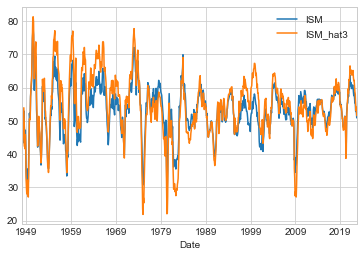

In [333]:
data[['ISM', 'ISM_hat3']].plot()
mse(data['ISM'].iloc[2:], data['ISM_hat3'].dropna())

In [334]:
# ISM - 10y VAR
model4 = VAR(data[['ISM_diff','10y_mom']].dropna()).fit(maxlags=4, ic='bic', trend='c')
model4.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 05, Mar, 2023
Time:                     14:08:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.657852
Nobs:                     728.000    HQIC:                 -0.665597
Log likelihood:          -1819.93    FPE:                   0.511472
AIC:                    -0.670463    Det(Omega_mle):        0.510070
--------------------------------------------------------------------
Results for equation ISM_diff
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.013736         0.083215           -0.165           0.869

Results for equation 10y_mom
           coefficient       std. error           t-stat            prob
-----------------------------------------------------------

In [335]:
model4_hat = model4.fittedvalues['ISM_diff'].rename('ISM_diff_hat4')
data['ISM_hat4'] = model4_hat.cumsum() + data['ISM']

33.402046099504965

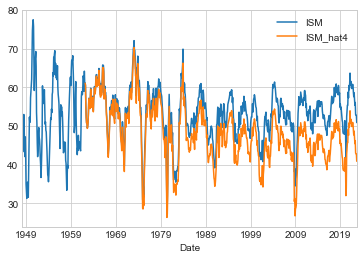

In [342]:
data[['ISM', 'ISM_hat4']].plot()
mse(data['ISM'].loc['1962-02':], data['ISM_hat4'].dropna())

In [ ]:
# VECM with S&P500 YoY and 10 year 12-month difference

#### ISM Time Series Predictability - Out-of-Sample

##### ISM-S&P Lead-Lag
See if lagged S&P can predict ISM better and vice-versa, Granger causality tests